# Random Forest Classification of protein-kinase cancer links

This notebook takes as input the data on Clinical Trials (according to year and phase) and embedded vectors that represent words and concepts in PubMed. It uses data collected up to a certain year (refered to as target year in the code, e.g., 2010), uses this data to train a Random Forest model, and assess how well the model predicts protein kinase - cancer links in future years. See the manuscript for details on the methods. 

In [1]:
import pandas as pd
import os
import sys
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve,precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KcetDatasetGenerator, KcetRandomForest

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035 Download the five files to a local directory and enter the path of this directory in the following input dialog

- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt
- clinical_trials_by_phase.tsv


To run this notebook, download all of these files to the same directory and enter the path to the directory after running the ``input()`` command.

In [2]:
download_dir = input()

 /home/peter/data/pubmed2vec


In [3]:
ctfile = os.path.join(download_dir, "clinical_trials_by_phase.tsv")
embeddings = os.path.join(download_dir, "embedding_SG_dim100_upto2010.npy")
words =  os.path.join(download_dir, "words_SG_upto2010.txt")
if not os.path.isfile(ctfile):
    raise FileNotFoundError("Could not find clinical trials file at %s" % ctfile)
if not os.path.isfile(embeddings):
    raise FileNotFoundError("Could not find 2010 embeddings file at %s" % embeddings)
if not os.path.isfile(words):
    raise FileNotFoundError("Could not find 2010 words file at %s" % words)    

### matplotlib code
The following function adds a single ROC curve to a matplotlib axis object. Together with the remaining code, we use this to plot multiple ROC curves in a single figure.

In [4]:
def plot_one_auc_curve(ax, y_test, yproba, midyear: str, num_years_later, n_pos_test):
    fpr, tpr, thresholds_auc = roc_curve(y_test,  yproba)
    auc_roc = roc_auc_score(y_test, yproba)
    
    ax.plot(fpr, tpr, label='%d-%d (%0.2f), n=%d' %(midyear, midyear + num_years_later  ,auc_roc, n_pos_test))
    #ax1.scatter(fpr[ix_gmeans], tpr[ix_gmeans], marker='o', color='black')

    precision, recall, thresholds_pr = precision_recall_curve(y_test, yproba)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    #print("precision", precision, 'recall', recall)
    diff_threshold = 0.01
    for i in range(len(fscore)):
        if abs(recall[i] - 0.5 * precision[i]) < diff_threshold:
            break
    # locate the index of the largest f score
    ix_fscore = i
    thresh = thresholds_pr[ix_fscore]
    fscore = fscore[ix_fscore]
    precision_at_threshold = precision_score(y_test, y_pred > thresholds_pr[ix_fscore])
    recall_at_threshold = recall_score(y_test, y_pred > thresholds_pr[ix_fscore])
    return thresh, fscore, precision_at_threshold, recall_at_threshold

In [5]:
datagen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words)

[INFO] Reading protein kinase information from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 698 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 698 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 76 entries
[INFO] Parsed data for 70 medications.


Iterations: ....

/tmp/ipykernel_237272/1321181885.py:10: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


......

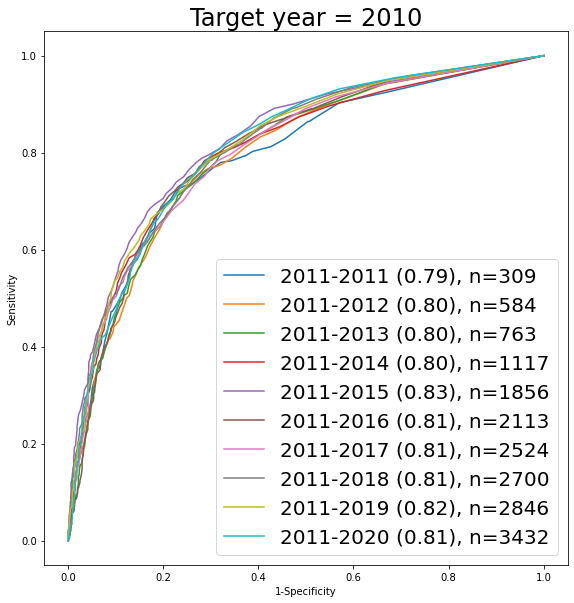

In [6]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.tight_layout()
font = {'family' : 'normal', 'size'   : 20}
matplotlib.rc('font', **font)

targetyear = 2010
midyear= 2011 

krf = KcetRandomForest(data_gen=datagen, target=targetyear, embedddingfile=embeddings, wordsfile=words)

pr_data = []

print("Iterations: ", end='')
for num_years_later in [0,1,2,3,4,5,6,7,8,9]:
    print(".", end = '')
    y_pred, y_test, yproba, n_pos_test = krf.classify(num_years_later=num_years_later, mid_year=midyear)
    # print(metrics.confusion_matrix(y_test,y_pred))
    thresh, fscore, precision_at_threshold, recall_at_threshold = plot_one_auc_curve(ax1, y_test, yproba, midyear, num_years_later, n_pos_test)
    pr_data.append({"years_later": num_years_later, 
                    "threshold": thresh, 
                    "f-score": fscore, 
                    "precision@threshold": precision_at_threshold, 
                    "recall@threshold": recall_at_threshold})
# show this below with results for P/R analysis
pr_df = pd.DataFrame(pr_data)
    
     
ax1.set_title('Target year = {}'.format(targetyear))
ax1.set_xlabel('1-Specificity')
ax1.set_ylabel('Sensitivity')
ax1.legend(loc="lower right")
    
plt.show()

# Precision recall results
The threshold refers to the threshold probability at which the highest F1 score was obtained. The remaining two columns show the precision and recall at these thresholds.
The analysis was performed for different combinations of years following the target year of 2010.

In [7]:
pr_df.set_index('years_later')

,threshold,f-score,precision@threshold,recall@threshold
years_later,,,,
0,0.240000,0.420601,0.769231,0.064725
1,0.225000,0.492622,0.762712,0.077055
2,0.225000,0.521286,0.786517,0.091743
3,0.170000,0.574645,0.901235,0.065354
4,0.220000,0.607477,0.955446,0.103987
5,0.205000,0.600880,0.902128,0.100331
6,0.170000,0.618671,0.966851,0.069334
7,0.170072,0.625770,0.964706,0.060741
8,0.180000,0.622306,0.969072,0.066058
